---
title: "mrfmsim paper CERMIT algorithm comparison"
author: Peter Sun
date: Nov 3, 2025
versions: mmodel 0.9.0, mrfmsim 0.4.1
---

In this notebook, we compare Moore's and Isaac's CERMIT saturation algorithm (Algorithm 1 and 2). Isaac's version is implemented in the `CermitESR` under `CermitESRGroup`. The simulations and figures in this notebook are used in the mrfmsim paper appendix.

The "figures" folder needs to be created to properly save the figures generated in this notebook.


The algorithm of Moore's 2009 PNAS [@Moore2009dec] was discussed in Isaac's thesis [@Isaac2018feb]. The conclusion was (page 254) that the grid size used by Moore was too coarse (~ 20 nm), and 1 - 2 nm spacing is needed. Isaac also showed that the resulting slice is discontinuous (Figure 8.4).

![](Issac_thesis_page255.jpeg)

Upon close inspection, the result is not intuitive because one would assume the discontinuation would be in the x direction. Also, if the grid size is smaller than the cantilever peak to peak (660 nm in Moore's calculation), the result shouldn't be that much different.

Here we are going to reproduce Moore and Isaac's work. The Marohn and Isaac's updated algorithm was modified (a small bug) and added to the current experiment list, under mrfmsim_marohn.experiment.CermitESR.

## Algorithm Comparison

Moore's algorithm is taken from the matlab file.

```Matlab
% PNAScopy5.m
%
% John's comments:
%
% The file runs a simulation to mimic Lei Chen's Oct 2011 experiments with
% a nickel tip in the SPAM geometry.
%
% Same as PNAScopy4.m, but increase tip-sample separation from 50 nm to 100
% nm.
%
% Eric's comments:
%
% This file runs a similar simulation to the one in Fig. 7 of the recent
% PNAS paper. Most of the parameters are specified either in the paper
% itself or in the supplement. I have not doubled checked all of them, and
% from the width of the signal something is off.  (Comparing to the paper is
% the best you can do, we don't have a copy of the original script used for
% the paper.)
%
% This simulation runs in just over 5 minutes on a good circa
% 2006 laptop, (9.6 million voxels, on a 1/2 model.)
%
% If you are running on a computer with less than 1.5G of RAM you will
% likely want (or need) to reduce the mesh size, see nx, ny, nz starting on
% line 115 below. A good first reduction would be to nx = 800, ny = 10, nz
% = 400. (9.6 million to 3.2 million voxels).
%
% Eric Moore
% 2011.4.30

```

The algorithm used to calculate the saturation is:

```Matlab
for i = 1:numel(r.Bostep)
    % Here we are defining the spins that are in resonance at the beginning
    % of the cantilever swing.

    % I'm a little concerned that switching this from a for loop to this
    % vectorized expression incurs large costs in terms of creation of
    % temp objects.
    rescond = s.Binit + r.Bostep(i) - Brf;  % delta omega in field units
    sBnew = (1 + (rescond/deltaB).^2) ./ (1 + (rescond/deltaB).^2 + sterm); % s.s. bloch equation for Mz/M0

    % sBnew is poorly named.  It contains the percentage of the original
    % magnetizion that remains in each sample point (in steady state) due
    % to the applied rf field.

    % Now we're moving that slice through the sample. By translating the
    % sBnew in along the x-axis and keeping the most saturated (ie smallest
    % remaining magnetization that we calculate at each point.  I'm using
    % this set of nested loops to avoid creating a sample mesh sized
    % temporary. (Hopefully, the temporaries, if any are created as only
    % NY*NZ in size. I have not checked that this is true.)

    % the array we will eventually integrate over is this subset of s.Binit
    nxb = s.th+1;
    nxe = s.th+s.nx;

    % swing 1/2 ampl
    for k = 1:s.th
        for m = nxb:nxe
            sBnew(:,m-1,:) = min(sBnew(:,m-1,:), sBnew(:,m,:));
        end
    end

    % swing the other 1/2 ampl
    for k = 1:s.th
        for m = nxe:-1:nxb
            sBnew(:,m+1,:) = min(sBnew(:,m+1,:), sBnew(:,m,:));
        end
    end

    % because we have calculated the remaining magnetization, but we really
    % need the magnetization that was lost, we need to subtract away what
    % remains, leaving what was lost.
    sBnew = 1-sBnew(:,nxb:nxe,:);

    % the number of spins in resonance
    % the 2 here and below is because we are calcuating a 1/2 model.
    r.nSFZ(i) = s.scale * r.rho * s.dV * sum(sBnew(:));
    % the simulated deltak
    % here we are resuing rescond, to prevent allocation of another giant
    % array.
    rescond = sBnew .* s.H;
    r.kAVG(i) = s.scale * r.mu * r.pol * r.rho * s.dV * sum(rescond(:));
    % assuming a spin noise experiment.
    rescond = rescond .* s.H  .* sBnew;
    r.kSQ(i) = s.scale * r.mu^2 * r.rho * s.dV * sum(rescond(:));
    nbksp = PrettyPrintKofN(i,numel(r.Bostep),nbksp);
end
```

The key function here is `sBnew(:,m-1,:) = min(sBnew(:,m-1,:), sBnew(:,m,:));`, simply keep the most saturated value between the given
sweep points. Here `s` is the sample object defined with the file "SampleCreate.m", "SampleFieldCreateSaturation.m", and `s.th` is number of grid points the cantilever swings; `s.nx` is the number of sample grid points in the x direction.

The algorithm goes like this:

Given a sample with step size `s.nx`. The cantilever motion extends the grid by `s.th`. The offset was calculated first for the extended grid, and then sliced according to the step.

Here we are going to replace the "minimum absolute offset" with Moore's method. Based on "PNAS.m" and "SampleSweepSaturation.m", the algorithm is to find the minimum.

The algorithm assumes that the lowest value in the sweep is the final amount. This is actually underestimating because the algorithm does not account for the case when the spin crosses 0 and changes signs.

On the other hand, Isaac's method is different.


In [1]:

from mrfmsim.experiment import CermitESRGroup

cermitesr = CermitESRGroup.experiments["CermitESR"]
# cermitesr.visualize()


## Moore Algorithm (Algorithm 1)


In [ ]:
import numpy as np


from mrfmsim.formula.math import as_strided_x


def min_abs_offset_moore(ext_B_offset, ext_pts):
    r"""Minimal B offset using Moore algorithm.

    The returned value is the minimal absolute offset.
    The sign does not matter because in the steady state saturation
    calculation, the b_offset**2 is used.

    The function calculates minimum absolute offset during the
    cantilever sweep. For example, we define the window is 3 (1 extended pts at
    each side of the grid) and the B offset of the extended grid
    is (-4, -3, -2, -1, 1, 2, 3, 4, 5). We use _ to represent the extended pts and
    -- to represent the true grid points:

    __ -- -- -- -- -- -- -- __
    -3 -2 -1  1  2  3  4  5
    -4 -3 -2 -1  1  2  3  4  5
       -4 -3 -2 -1  1  2  3  4

    Moore algorithm result:

    __ -- -- -- -- -- -- -- __
    __  2  1  1  1  1  2  3 __

    In comparison, the Isaac-Marohn algorithm result:

    __ -- -- -- -- -- -- -- __
    __  2  1  0  0  1  2  3 __

    """
    window = 2 * ext_pts + 1
    b_offset_abs_strided = as_strided_x(abs(ext_B_offset), window)

    return b_offset_abs_strided.min(axis=1)


# cermitesr_moore.visualize()

Here we replicate the algorithm in Python. We can test and compare the algorithm.
The algorithm uses the same `as_strided_x` as CermitESR, basically extending the grid view
in the x direction to save memory and increase performance.

We will test the algorithm with a 1D array.


In [3]:
def test_min_abs_offset_moore():
    """Test min_abs_offset_moore function."""
    ext_B_offset = np.array([-4, -3, -2, -1, 1, 2, 3, 4, 5])
    ext_pts = 1
    expected = np.array([2, 1, 1, 1, 1, 2, 3])
    return np.array_equal(min_abs_offset_moore(ext_B_offset, ext_pts), expected)


test_min_abs_offset_moore()

True

## Isaac Algorithm (Algorithm 2)

The algorithm from mrfmsim-marohn is efficient; however, the peak memory creates three copies of the array during the zero crossing calculation.

However, alternative algorithms that reduce the peak memory usage are extremely slow (even with the jit options).
The commented out code below is one example.


In [4]:
min_abs_offset_isaac = cermitesr.get_node_object("minimum absolute x offset").func


def test_min_abs_offset_isaac():
    """Test min_abs_offset_isaac function."""
    ext_B_offset = np.array([-4, -3, -2, -1, 1, 2, 3, 4, 5])
    ext_pts = 1
    expected = np.array([2, 1, 0, 0, 1, 2, 3])
    # return np.array_equal(min_abs_offset_isaac(ext_B_offset, ext_pts), expected)
    return np.testing.assert_array_equal(min_abs_offset_isaac(ext_B_offset, ext_pts), expected)

test_min_abs_offset_isaac()

The difference between the algorithms is quite clear. Given the assumption that the spins
saturate immediately, Moore's algorithm underestimates the effect. The underestimation
also depends on the grid step size. In the previous example, the smaller the grid step size,
the closer the value is to Isaac's algorithm.

Now with the time-dependent offset physics, we know that the assumption stated above drastically
overestimates the local spins.

Here we compare Moore's algorithm and Isaac's algorithm for the 2009 experiment.
Here we use the same dataset as the mrfmsim paper. (The separate Moore run for comparison.)

Here we look at two different tip sample separations for comparison.


In [5]:
# import scipy.signal as signal
import scipy.io
import numpy as np
import matplotlib.pyplot as plt


class freqvsfield(object):
    def __init__(self, filename, title, n):
        self.filename = filename
        self.title = title
        self.n = n

    def load(self):
        """Read the data."""

        mat = scipy.io.loadmat(self.filename)

        data = mat["data"]

        self.f = data
        self.F = data[0, self.n][0, 0][7][0]
        self.X = data[0, self.n][0, 0][5][0]
        self.Y = data[0, self.n][0, 0][6][0]
        # self.p_opt = 0
        # self.message = f.attrs['comment']
        # self.tip_sample = f.attrs['tip-sample_separation']

    def plot(self, inline=True):
        """Plot the X and Y lock-in data versus."""

        plt.figure()
        plt.plot(self.F, self.X, "-o", color="teal", label="X")
        plt.plot(self.F, self.Y, "-", color="grey", label="Y")
        plt.xlabel("B$_0$ [kG]")
        # plt.xlim([34.4,38])
        plt.ylabel("signal [mHz]")
        # plt.ylim([-200,250])
        # plt.vlines(x=1.236*28, ymin=-30, ymax=30, color='g', linestyles = 'dashed')
        plt.title(self.title)
        plt.legend(loc="best")
        plt.grid()
        plt.show()

    def baseline(self, mask):
        self.X = self.X - np.average(self.X[mask])
        self.Y = self.Y - np.average(self.Y[mask])

    def phase(self, p0=0):
        """Autocorrect the phase."""

        phases = np.pi * (np.linspace(0.0, 1.0, 512) + p0)
        rX = np.zeros(phases.size)
        rY = np.zeros(phases.size)

        for idx, p in enumerate(phases):
            Xp = np.cos(p) * self.X + np.sin(p) * self.Y
            Yp = np.sin(p) * self.X - np.cos(p) * self.Y

            rX[idx] = (Xp * Xp).sum()
            rY[idx] = (Yp * Yp).sum()

        self.p_opt = phases[rY.argmin()]

        # print(self.p_opt)
        Xnew = np.cos(self.p_opt) * self.X + np.sin(self.p_opt) * self.Y
        Ynew = np.sin(self.p_opt) * self.X - np.cos(self.p_opt) * self.Y

        self.Xorig = self.X
        self.Yorig = self.Y

        self.X = Xnew
        self.Y = Ynew

    def pick_phase(self, p0=0):
        """Autocorrect the phase."""

        phases = np.pi * (np.linspace(0.0, 1.0, 512) + p0)
        rX = np.zeros(phases.size)
        rY = np.zeros(phases.size)

        for idx, p in enumerate(phases):
            Xp = np.cos(p) * self.X + np.sin(p) * self.Y
            Yp = np.sin(p) * self.X - np.cos(p) * self.Y

            rX[idx] = (Xp * Xp).sum()
            rY[idx] = (Yp * Yp).sum()

        self.p_opt = phases[rY.argmin()]

        # print(self.p_opt)
        Xnew = np.cos(self.p_opt) * self.X + np.sin(self.p_opt) * self.Y
        Ynew = np.sin(self.p_opt) * self.X - np.cos(self.p_opt) * self.Y

        self.Xorig = self.X
        self.Yorig = self.Y

        self.X = Xnew
        self.Y = Ynew

In [6]:
import numpy as np
import matplotlib.pyplot as plt

data = {}
filename = "data/moore/Moore 20081201 distance dependence.mat"

# Moore nb 3 pp 74
mat = scipy.io.loadmat(filename)
for i in range(10):
    tip_samp = float(mat["data"][0, i][0, 0][3][0].split(" ")[0])

    a = freqvsfield(filename, "tip sample = " + str(tip_samp), i)
    a.load()
    if tip_samp < 100.0:
        a.baseline(a.F > 8.0)
        a.phase(0.0)

        std = np.std(a.X[a.F > 8.0])
        mean = np.mean(a.X[a.F > 8.0])

        # print(std)

        val, k = 0, 0
        while abs(val - mean) < 2 * std:
            k = k - 1
            val = a.X[k]

        a.bound = a.F[k]

    else:
        a.baseline(a.F > 7.75)
        a.phase(0.0)

        std = np.std(a.X[a.F > 7.75])
        mean = np.mean(a.X[a.F > 7.75])

        val, k = 0, 0
        while abs(val - mean) < 4 * std:
            k = k - 1
            val = a.X[k]

        a.bound = a.F[k]

    a.angle = np.arctan2(a.Y, a.X)

    data[tip_samp] = a
# sort
data = dict(sorted(data.items()))

### Conversion to float32

Due to multiple copies during the calculation, here we convert all parameters into float32 during calculation.
The simplest thing is to convert all intermediate data to float32. Some operations are repeated, but overall
we still improve performance.


In [7]:
from functools import wraps


def convert_float32(value):
    """Convert float, numpy array and list of float to float32.

    Here we assume all lists used in the cermitesr is a list of float
    or int.
    """
    if isinstance(value, np.ndarray) or isinstance(value, float):
        return np.float32(value)
    elif isinstance(value, list) or isinstance(value, tuple):
        v_list = []
        for v in value:
            if isinstance(v, int):
                v_list.append(v)
            else:
                v_list.append(np.float32(v))

        return type(value)(v_list)
    return value


def float32_modifier(func):
    """Modifier to convert all input and output to float32."""

    @wraps(func)
    def wrapper(**kwargs):

        kwargs32 = {key: convert_float32(value) for key, value in kwargs.items()}

        return convert_float32(func(**kwargs32))

    return wrapper

In [8]:
cermitesr32 = cermitesr.edit(modifiers=[float32_modifier])

for node in cermitesr32.graph.nodes:
    cermitesr32 = cermitesr32.edit_node(node, modifiers=[float32_modifier])

cermitesr_moore32 = cermitesr32.edit_node(
    "minimum absolute x offset", func=min_abs_offset_moore
)

## Appendix

In the paper appendix, we also compare the Moore algorithm (Algorithm 1) with Isaac algorithm (Algorithm 2).

Particularly, we focus on the three B fields (645, 657.5, 707.5 mT) at 358.7 nm. First we implement the CERMITESR.


In [9]:
from mrfmsim.component import SphereMagnet, Grid, Sample, Cantilever
import numpy as np

magnet = SphereMagnet(magnet_radius=1375.9, mu0_Ms=523.1, magnet_origin=[0, 1375.9, 0.0])
sample = Sample(spin="e", T1=1.3e-3, T2=0.45e-6, spin_density=0.0241, temperature=11.0)
# eric moore spam geometry, very shallow grid
grid = Grid(grid_shape=(501, 11, 1101), grid_step=[20.0, 20.0, 20.0], grid_origin=[0.0, -100.0, 0.0])
cantilever = Cantilever(k_c=7.8e2, f_c=5.512e3)

# # we use the same coil constant
# c_uT = 1.0 / 1.2  # coil constant uT^2/mW
# dBm = -10.0  # dB gain
# power = 10.0 ** ((dBm + 20.0) / 10.0)  # mW
# B1 = np.sqrt(power * c_uT) / 1000.0  # mT

# We use the coil constant of 0.00029 uT^2/mW
B1 = 0.00029  # mT, this is the amplitude of the RF field
x_0p = 164.0
tip_v = x_0p * cantilever.f_c * 2 * np.pi

# eric pulses every three cycles
dt_step = 1 / cantilever.f_c * 3
f_rf = 18.1e9  # Hz
# f_rf = 17.7e9  # Hz, this is the frequency of the RF field

# h_list = ([[0, d, 0] for d in d_list])  # tip sample separation [nm]
h = [0, 358.7, 0]  # tip sample separation [nm]

h_list = ([[0, d, 0] for d in [53.0, 358.7, 665.4, 972.2]]) 
mw_x_0p = x_0p  # zero to peak amplitude of the cantilever motion [nm]

B0_list = np.arange(600, 805, 2.5)

We compare the signal to verify it is similar between the float32 and float64 operations.


In [10]:
sig64 = cermitesr(
    B0_list[20], B1, cantilever, f_rf, grid, h, magnet, mw_x_0p, sample
)
sig32 = cermitesr32(
    B0_list[20], B1, cantilever, f_rf, grid, h, magnet, mw_x_0p, sample
)

print(
    f"signal calculated with float64 at 50 nm tip sample separation: {sig64} and float32: {sig32}"
)

signal calculated with float64 at 50 nm tip sample separation: -1.1210441226222698 and float32: -1.1209359169006348


### Comparison between different algorithms

Here we are going to use the parameters used for the time-dependent algorithm.

The grid used here has the shape of (1201, 11, 1201) and step size of
(20, 20, 20) nm. The effective grid size is 24.02 um x 220 nm x 24.02 um.

We pick two different tip sample separations to plot.


In [11]:
from mmodel.shortcut import loop_shortcut

cermitesr32_loop = loop_shortcut(loop_shortcut(cermitesr32, "B0"), "h")
cermitesr_moore32_loop = loop_shortcut(loop_shortcut(cermitesr_moore32, "B0"), "h")

## Algorithm grid size comparison


In [12]:
grid = Grid(grid_shape=(501, 11, 1101), grid_step=[20.0, 20.0, 20.0], grid_origin=[0.0, -100.0, 0.0])
grid_10nm = Grid(grid_shape=(1001, 11, 1101), grid_step=[10, 20, 20], grid_origin=[0.0, -100.0, 0.0])
grid_5nm = Grid(grid_shape=(2001, 11, 1101), grid_step=[5, 20, 20], grid_origin=[0.0, -100.0, 0.0])
grid_2_5nm = Grid(grid_shape=(4001, 11, 1101), grid_step=[2.5, 20, 20], grid_origin=[0.0, -100.0, 0.0])

In [13]:
moore_result_10nm = cermitesr_moore32_loop(
    B0_list,
    B1,
    cantilever,
    f_rf,
    grid_10nm,
    h_list,
    magnet,
    mw_x_0p,
    sample,
)

moore_result_5nm = cermitesr_moore32_loop(
    B0_list, B1, cantilever, f_rf, grid_5nm, h_list, magnet, mw_x_0p, sample
)

moore_result_2_5nm = cermitesr_moore32_loop(
    B0_list, B1, cantilever, f_rf, grid_2_5nm, h_list, magnet, mw_x_0p, sample
)

moore_result = cermitesr_moore32_loop(
    B0_list, B1, cantilever, f_rf, grid, h_list, magnet, mw_x_0p, sample
)

In [14]:

issac_result = cermitesr32_loop(
    B0_list, B1, cantilever, f_rf, grid, h_list, magnet, mw_x_0p, sample
)

# There is no significant change in the results for Isaac's algorithm
# Uncomment the following lines to run different
# issac_result_10nm = cermitesr32_loop(
#     B0_list, B1, cantilever, f_rf, grid_10nm, h_list, magnet, mw_x_0p, sample
# )

# issac_result_5nm = cermitesr32_loop(
#     B0_list, B1, cantilever, f_rf, grid_5nm, h_list, magnet, mw_x_0p, sample
# )


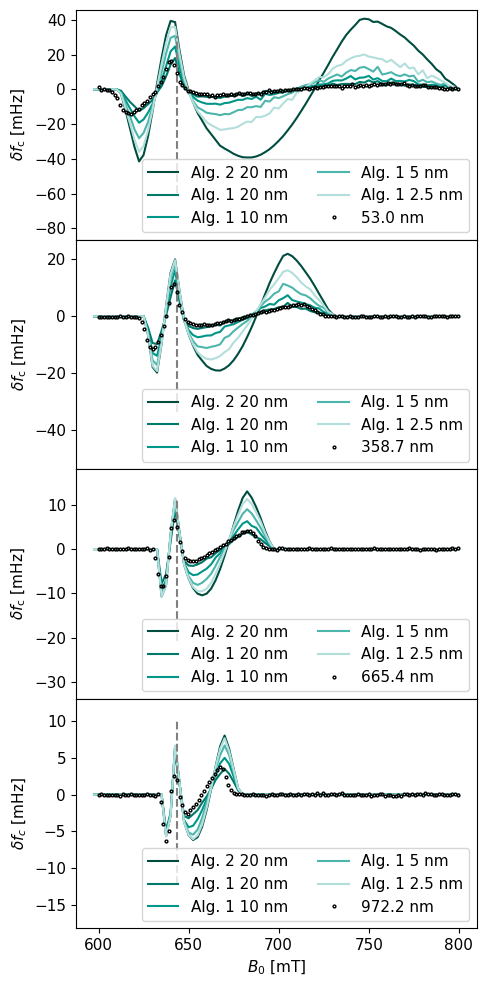

In [15]:
import matplotlib.pyplot as plt
B_larmor = f_rf / sample.Gamma * 2 * np.pi
subdata = {
    53.0: data[53.0],
    358.7: data[358.7],
    665.4: data[665.4],
    972.2: data[972.2],
}

colors = [
    '#004D40',  # Dark teal
    '#00796B',  # Medium-dark teal
    '#009688',  # Medium teal
    '#4DB6AC',  # Medium-light teal
    '#B2DFDB'   # Light teal
]
plt.rcParams.update({'font.size': 11})
fig = plt.figure(figsize=(5, 2.5 * len(subdata)))

gs = fig.add_gridspec(len(subdata), hspace=0.0)
axs = gs.subplots(sharex=True, sharey=False)

for i, d in enumerate(subdata.keys()):

    
    # axs[i].plot(B0_list, cermittd_result[i], color="teal", label="TD")
    axs[i].plot(B0_list - 2.5, issac_result[i], color=colors[0], label="Alg. 2 20 nm")
    axs[i].plot(B0_list - 2.5, moore_result[i], color=colors[1], label="Alg. 1 20 nm")
    axs[i].plot(B0_list - 2.5, moore_result_10nm[i], color=colors[2],label="Alg. 1 10 nm")
    axs[i].plot(B0_list - 2.5, moore_result_5nm[i], color=colors[3],label="Alg. 1 5 nm")
    axs[i].plot(B0_list - 2.5, moore_result_2_5nm[i], color=colors[4],label="Alg. 1 2.5 nm")


    axs[i].vlines(
        x=B_larmor - 2.5,
        ymin=min(issac_result[i]) - 18 + i*4,
        ymax=max(issac_result[i]) - 10 + i*4,
        color="grey",
        linestyles="dashed",
        # label="Larmor",
    )
    axs[i].plot(
        subdata[d].F[0:134] * 100,
        subdata[d].X[0:134] * 1000.0,
        "o",
        mfc="none",
        color="black",
        markersize=2,
        label=f"{d} nm",
    )
    axs[i].set_ylabel('$\delta f_{\mathrm{c}}$ [mHz]')
    axs[i].set_ylim([min(issac_result[i]) - 45 + i*11, max(issac_result[i]) + 5])
    axs[i].legend(loc="lower right", ncol=2, bbox_to_anchor=(1, 0))

plt.xlabel("$B_0$ [mT]")
plt.ylabel(r"$\delta f_c$ [mHz]")

plt.tight_layout()
plt.savefig("figures/cermit_algo_comparison.pdf", bbox_inches="tight", dpi=300)
plt.show()